In [4]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [6]:
 # relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha'
data_file_name = f'{data_set_name}.csv.tar.gz'
re_data = load_re_data(data_dir, 
                                data_file_name,
                                usecols = ["model_name",
                                           'n_sentence_pool',
                                           "ds",
                                           "init_coms",
                                           'weight_account', 
                                           'weight_systematicity',
                                           "fixed_point_coms_consistent",
                                           "n_fixed_points",
                                           "n_global_optima",
                                           "fp_full_re_state",
                                           "go_full_re_state",
                                           'n_full_re_states',
                                           'fixed_point_is_full_re_state',
                                           'error_code'
                                           ],
                               evalcols = [
                                    "fp_full_re_state",
                                    "go_full_re_state"
                                   ],
                              filter_erroneous_runs = True)

In [7]:
# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [8]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 4136547
   Number of dialectical structures: 200
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [9]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'fixed_point_coms_consistent',
       'error_code', 'n_fixed_points', 'fixed_point_is_full_re_state',
       'n_global_optima', 'go_full_re_state', 'n_full_re_states',
       'fp_full_re_state', 'model_short_name'],
      dtype='object')

## Setup Dataframes

In [209]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point, 
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setups
"""
analyse_branches = True

"""Whether bootstrapping is applied to estimate mean and standard deviation"""
bootstrap = True
n_resamples = 400

grouping = ["model_name"]

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = True

In [210]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity', 
                         'init_coms'
                        ])

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 'n_sentence_pool',
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity",
                                 #'n_global_optima',
                                 'go_full_re_state',
                                 #'n_full_re_states'
                                ]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_full_re_state`)
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      'n_sentence_pool',
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity",
                                     ]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(2845799, 7)

In [211]:
re_data_unique_setups.groupby("model_name")["ds"].size().reset_index().sort_values("ds", ascending=False)

,model_name,ds
0,LinearGlobalRE,143973
2,QuadraticGlobalRE,143964
3,QuadraticLocalRE,143079
1,LinearLocalRE,142219


In [212]:
# two models variants for global optima graphics in order to avoid (almost) redundant results
# criterion:  fewest erroneous runs
go_models = ["LinearGlobalRE", "QuadraticGlobalRE"]

In [213]:
# this corresponds to a grouping according to simulation setups

#go_data["rel_go_full_re"] = go_data["n_full_re_states"]/go_data["n_global_optima"]
#go_data.groupby("model_name")["rel_go_full_re"].describe()


In [214]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       'n_sentence_pool',
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       'fixed_point_is_full_re_state']]
    
    # rename fixed point columns 
    # note: df is already exploded
    exploded_fp_data = fp_data.rename(columns={'fixed_point_is_full_re_state': "fp_full_re_state",})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     'n_sentence_pool',
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "fp_full_re_state",
                                     #"n_fixed_points"
                                    ]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `fp_full_re_state`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          'n_sentence_pool',
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(4136547, 7)

In [215]:
## number of endpoints

In [216]:
#for endpoint_type in ["fixed_points", "global_optima"]:
#
#    n_min = re_data_unique_setups.groupby(["weight_account", 
#                                           "weight_systematicity"])[f"n_{endpoint_type}"].mean().min()
#    n_max = re_data_unique_setups.groupby(["weight_account", 
#                                           "weight_systematicity"])[f"n_{endpoint_type}"].mean().max()
#
#    title_text = 'Number of {}'.format("global optima" if endpoint_type=="global_optima" else "fixed points")
#
#    heat_maps_by_weights(re_data = re_data_unique_setups, 
#                         values = f"n_{endpoint_type}", 
#                         title = title_text,
#                         annot_std = True,
#                         annot_fmt="{:2.2f}\n", 
#                         annot_std_fmt = r'$\pm${:2.2f}',
#                         vmin = n_min,
#                         vmax = n_max,
#                         bootstrap=True,
#                         n_resamples=400)
#
#    
#    
#    plt.savefig(path.join(figures_output_dir, 'hm_n_{}.png'.format(endpoint_type)), bbox_inches='tight')
#    
#    #plt.show()

In [217]:
re_data_unique_setups.groupby("model_name")["n_global_optima"].sum()

model_name
LinearGlobalRE       700830
LinearLocalRE        721096
QuadraticGlobalRE    714584
QuadraticLocalRE     709289
Name: n_global_optima, dtype: int64

In [218]:
re_data_unique_setups.groupby("model_name")["n_fixed_points"].sum()

model_name
LinearGlobalRE       312783
LinearLocalRE        228122
QuadraticGlobalRE    458147
QuadraticLocalRE     588236
Name: n_fixed_points, dtype: int64

In [219]:
re_data_unique_setups.groupby("model_name")["n_global_optima"].size()

model_name
LinearGlobalRE       143973
LinearLocalRE        142219
QuadraticGlobalRE    143964
QuadraticLocalRE     143079
Name: n_global_optima, dtype: int64

### Overall relative shares

In [171]:
#grouped_go_data=exploded_go_data.groupby(grouping)["go_full_re_state"].agg(["sum", "size"]).reset_index()
#    
#grouped_go_data = grouped_go_data.rename(columns={'sum': "n_go_full_re_state",
#                                                      'size': 'n_global_optima'})

In [172]:
#grouped_go_data["n_global_optima"].sum()

In [173]:
# relative shares
#grouped_go_data["rel_go_full_re"] = grouped_go_data["n_go_full_re_state"]/grouped_go_data["n_global_optima"]

In [174]:
#grouped_go_data

In [175]:
#fp_data.shape

In [176]:
#grouped_fp_data=exploded_fp_data.groupby(grouping)["fp_full_re_state"].agg(["sum", "size"]).reset_index()
#    
#grouped_fp_data = grouped_fp_data.rename(columns={'sum': "n_fp_full_re_state",
#                                                      'size': 'n_fixed_points'})

In [177]:
#if analyse_branches:
#    
#    grouped_fp_data=fp_data.groupby(grouping)["fp_full_re_state"].agg(["sum", "size"]).reset_index()
#    
#    grouped_fp_data = grouped_fp_data.rename(columns={'sum': "n_fp_full_re_state",
#                                                      'size': 'n_fixed_points'})
#else:
#    
#    fp_data["n_fp_full_re_state"] = fp_data["fp_full_re_state"].map(sum)

In [178]:
#fp_data.head()

In [179]:
#grouped_fp_data["n_fixed_points"].sum()

In [180]:
# relative shares
#grouped_fp_data["rel_fp_full_re"] = grouped_fp_data["n_fp_full_re_state"]/grouped_fp_data["n_fixed_points"]

In [181]:
#grouped_fp_data

## Tables

In [182]:
#model_short_names = {'StandardGlobalReflectiveEquilibrium':'QuadraticGlobalRE',
#                     'StandardLocalReflectiveEquilibrium':'QuadraticLocalRE',
#                     'StandardGlobalReflectiveEquilibriumLinearG': 'LinearGlobalRE',
#                     'StandardLocalReflectiveEquilibriumLinearG': 'LinearLocalRE'
#                    }
#
#
## Adding model short names
#go_data['model_name'] = go_data['model_name'].map(lambda x: model_short_names[x])
#fp_data['model_name'] = fp_data['model_name'].map(lambda x: model_short_names[x])

In [183]:
#fp_data.groupby("model_name")[["rel_fp_full_re", 
#                               "n_fp_full_re_state",
#                               "n_fixed_points"]].agg({"rel_fp_full_re":"mean",
#                                                       "n_fp_full_re_state":"sum",
#                                                       "n_fixed_points":"sum"})

In [184]:
#fp_data.groupby("model_name")[["rel_fp_full_re", 
#                               "n_fp_full_re_state",
#                               "n_fixed_points"]].agg({"rel_fp_full_re":"mean",
#                                                       "n_fp_full_re_state":"sum",
#                                                       "n_fixed_points":"sum"})

In [185]:
# if not analyse_branches:
#     
#     # group by simulation setup and calculate mean over relative shares of consistency cases
#     fp_overall_results = fp_data.groupby(['model_name',
#                                                'ds',
#                                                'init_coms',
#                                                'weight_account',
#                                                'weight_systematicity'
#                                               ])["rel_fp_full_re"].mean().reset_index()
#     
#     # and then group by model_name only
#     fp_overall_results = fp_overall_results.groupby(['model_name',
#                      #'ds',
#                      #'init_coms',
#                      #'weight_account',
#                      #'weight_systematicity'
#                      ])["rel_fp_full_re"].mean().round(2).reset_index()
#     
# else:
#     fp_overall_results = fp_data[["model_name", "rel_fp_full_re"]].round(2)

In [186]:
# group by model_name only
#fp_overall_results = grouped_fp_data.groupby(['model_name',
#                      #'ds',
#                      #'init_coms',
#                      #'weight_account',
#                      #'weight_systematicity'
#                      ])["rel_fp_full_re"].mean().reset_index()
#
#go_overall_results =grouped_go_data.groupby(['model_name',
#                     #'ds',
#                     #'init_coms',
#                     #'weight_account',
#                     #'weight_systematicity'
#                     ])["rel_go_full_re"].mean().reset_index()

In [187]:
#fp_overall_results

In [188]:
# group by simulation setup and calculate mean over relative shares of consistency cases
#o_overall_results = go_data.groupby(['model_name',
#                                              'ds',
#                                              'init_coms',
#                                              'weight_account',
#                                              'weight_systematicity'
#                                             ])["rel_go_full_re"].mean().reset_index()

#o_overall_results = go_overall_results.groupby(['model_name',
#                    #'ds',
#                    #'init_coms',
#                    #'weight_account',
#                    #'weight_systematicity'
#                    ])["rel_go_full_re"].mean().round(2).reset_index()

In [189]:
#go_overall_results

In [190]:
# separate tables for go and fp

#for df, endpoint_type in zip([grouped_go_data, grouped_fp_data], ["go", "fp"]):
#    
#    # sort by model name
#    df['model_name'] = pd.Categorical(df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#    df.sort_values("model_name", inplace=True)
#    
#    # Changing col names for readability
#    cols_for_tables = {'model_name':'Model',
#                   'n_go_full_re_state': 'Number of full RE global optima',
#                   'n_global_optima': 'Number of global optima',
#                   'rel_go_full_re': 'Relative share of full RE global optima',
#                   'n_fp_full_re_state': 'Number of full RE fixed points',
#                   'n_fixed_points': 'Number of fixed points',
#                   'rel_fp_full_re': 'Relative share of full RE fixed points',
#                  }
#
#    display(df.rename(columns=cols_for_tables))
#    
#    
#    if export_results:
#        file_name = 'table_full_re_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
#        df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
#    

In [191]:
# separate tables for go and fp

for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = rel_share_of_property(df, 
                           "{}_full_re_state".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name',
                                                   'ds',
                                                   'init_coms', 
                                                   'weight_account', 
                                                   'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    result_df.reset_index(inplace=True)
    
    # for later use
    if endpoint_type == "go":
        go_result_df = result_df
    else:
        fp_result_df = result_df
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   'sum_go_full_re_state': 'Number of full RE global',
                   'size_go_full_re_state': 'Number of global optima',
                   'rel_go_full_re_state': 'Relative share of full RE global optima',
                   'std_go_full_re_state': 'Standard deviation', 
                   'sum_fp_full_re_state': 'Number of full RE fixed points',
                   'size_fp_full_re_state': 'Number of fixed points',
                   'rel_fp_full_re_state': 'Relative share of full RE fixed points',
                   'std_fp_full_re_state': 'Standard deviation',  
                  }

    display(result_df.rename(columns=cols_for_tables))
    
    
    if export_results:
        file_name = 'table_full_re_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        result_df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)

,Model,Relative share of full RE global optima,Standard deviation,Number of full RE global,Number of global optima
2,QuadraticGlobalRE,0.115197,0.000380,82318,714584
0,LinearGlobalRE,0.274773,0.000524,192559,700830
3,QuadraticLocalRE,0.115262,0.000369,81750,709289
1,LinearLocalRE,0.254990,0.000487,183875,721096


,Model,Relative share of full RE fixed points,Standard deviation,Number of full RE fixed points,Number of fixed points
2,QuadraticGlobalRE,0.093137,0.000444,42660,458147
0,LinearGlobalRE,0.234884,0.000779,73477,312783
3,QuadraticLocalRE,0.052056,0.000287,30616,588236
1,LinearLocalRE,0.198387,0.000836,45241,228122


In [192]:
#overall_result_df = go_overall_results.join(fp_overall_results.set_index("model_name"), on="model_name")
#overall_result_df

In [193]:
# Changing col names for readability
#cols_for_tables = {'model_name':'Model',
#                   'rel_go_full_re': 'Relative share of full RE states among global optima',
#                   'rel_fp_full_re': 'Relative share of full RE states among fixed_points',
#                  }
#
#display(overall_result_df.rename(columns=cols_for_tables))

In [194]:
# Export
#if export_results:
#    file_name = 'table_rel_full_re_go_fp_{}.csv'.format('branches' if analyse_branches else 'setups')
#    overall_result_df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)

## Plots

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt

In [196]:

viridis = ["#472c7a", "#2c718e", "#29ae80", "#b0dd31"]
coolwarm = ['#6788ee', '#9abbff', '#e26952', '#f7a889']

### Barplots

In [197]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [198]:
viridis_map = {"QuadraticGlobalRE":"#472c7a", 
               "LinearGlobalRE":"#2c718e", 
               "QuadraticLocalRE":"#29ae80", 
               "LinearLocalRE": "#b0dd31"}

coolwarm_map = {"QuadraticGlobalRE":'#6788ee', 
               "LinearGlobalRE":'#e26952', 
               "QuadraticLocalRE":'#9abbff', 
               "LinearLocalRE": '#f7a889'}

In [199]:
#grouped_go_data["rel_go_full_re"] = grouped_go_data["rel_go_full_re"].astype(float)
#grouped_fp_data["rel_fp_full_re"] = grouped_fp_data["rel_fp_full_re"].astype(float)

In [200]:
for df, endpoint_type in zip([fp_result_df, go_result_df], ['fp', 'go']):
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdf = df[df["model_name"].isin(go_models)]
        rcoolwarm=coolwarm[0::2]
        
    else:
        rdf=df
        rcoolwarm = coolwarm

    
    fig = go.Figure(data=[go.Bar(x=rdf["model_name"],
                                 y=rdf.round(3)[f"rel_{endpoint_type}_full_re_state"],
                                 text=rdf.round(3)[f"rel_{endpoint_type}_full_re_state"],
                                 marker_color=rcoolwarm
                                )
                         ])
    

    fig.update_layout(showlegend=False)
    
    fig.update_yaxes(range=[0.0, 1.0])
    
    fig.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       width=800 if endpoint_type=="fp" else 500,
                       #margin={"t":80}
                      )

    fig.update_xaxes(title="Model variant", showticklabels=True, showgrid=False, linecolor= 'DarkGrey')
    fig.update_yaxes(title="Relative share", 
                     ticks="outside", 
                     tickcolor="DarkGrey", 
                     showgrid=False, 
                     linecolor='DarkGrey', 
                     zeroline=True, 
                     zerolinecolor="DarkGrey",
                     zerolinewidth=1)
    
    fig.update_layout(legend_title_text="")
    
    endpoints = "global optima" if endpoint_type=="go" else "fixed points"
    
    if (endpoint_type == "fp") & (analyse_branches):
        endpoints += " (all branches)"
    
    #fig.update_layout(title_text="Relative share of full RE states among {}".format(endpoints))
    
    

    fig.show()
    
    if export_results:
        file_name = 'full_re_{}_{}.png'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)
        
        file_name = 'full_re_{}_{}.pdf'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)

    
        


### By Sentence Pool Sizes

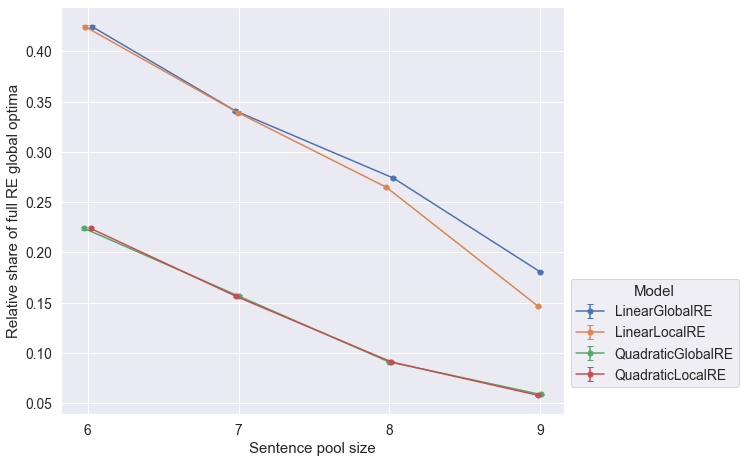

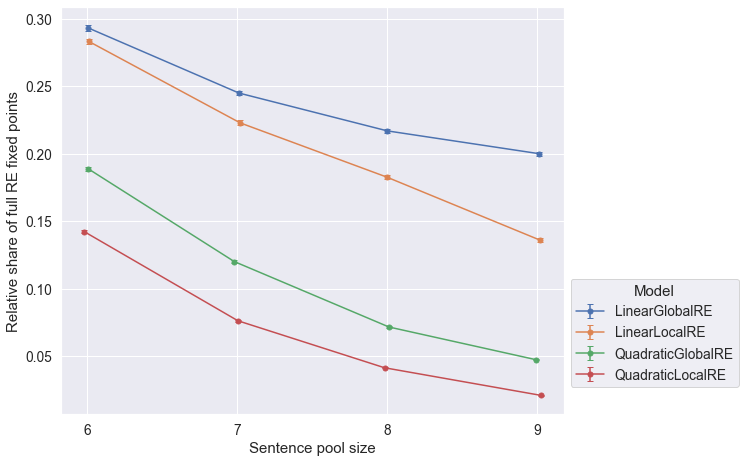

In [201]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = rel_share_of_property(df, 
                           "{}_full_re_state".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols= ["model_name", "n_sentence_pool"],
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
    perspective = "pp" if analyse_branches else "rp"
    
    file_name = None
    if export_results:
        file_name = f"rel_full_re_{endpoint_type}_by_sp_{perspective}"
    
    
    
    plot_multiple_error_bars(result_df.reset_index(), 
                             var_y = f"rel_{endpoint_type}_full_re_state", 
                             ylabel = f"Relative share of full RE {endpoint}",
                             xlabel = "Sentence pool size",
                             var_std=f"std_{endpoint_type}_full_re_state",
                             file_name=file_name,
                             output_dir = figures_output_dir)
    
    plt.show()

### Heatmaps

In [202]:
#new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [203]:
#wgrouped_go_data=exploded_go_data.groupby(new_grouping)["go_full_re_state"].agg(["sum", "size"]).reset_index()
#    
#wgrouped_go_data = wgrouped_go_data.rename(columns={'sum': "n_go_full_re_state",
#                                                      'size': 'n_global_optima'})
#
## relative shares
#wgrouped_go_data["rel_go_full_re"] = wgrouped_go_data["n_go_full_re_state"]/wgrouped_go_data["n_global_optima"]
#wgrouped_go_data["rel_go_full_re"] = wgrouped_go_data["rel_go_full_re"].astype(float).round(2)
#
## sort by model name
#wgrouped_go_data['model_name'] = pd.Categorical(wgrouped_go_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#wgrouped_go_data.sort_values("model_name", inplace=True)

In [204]:
#wgrouped_fp_data=exploded_fp_data.groupby(new_grouping)["fp_full_re_state"].agg(["sum", "size"]).reset_index()
#    
#wgrouped_fp_data = wgrouped_fp_data.rename(columns={'sum': "n_fp_full_re_state",
#                                                      'size': 'n_fixed_points'})
#
## relative shares
#wgrouped_fp_data["rel_fp_full_re"] = wgrouped_fp_data["n_fp_full_re_state"]/wgrouped_fp_data["n_fixed_points"]
#
#wgrouped_fp_data["rel_fp_full_re"] = wgrouped_fp_data["rel_fp_full_re"].astype(float).round(2)
#
## sort by model name
#wgrouped_fp_data['model_name'] = pd.Categorical(wgrouped_fp_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#wgrouped_fp_data.sort_values("model_name", inplace=True)

In [205]:
#normalized_heat_maps_by_weights(wgrouped_go_data, 
#                                "rel_go_full_re", 
#                                "Relative share of full RE states among global optima",
#                                annot_std = False,
#                                #annot_fmt="{:2.2f}\n"
#                               )
#      
#branches = "branches" if analyse_branches else "setups"
#        
#if export_results:
#    plt.savefig(path.join(figures_output_dir, 'rel_go_full_re_{}.png'.format(branches)), bbox_inches='tight')
#    plt.savefig(path.join(figures_output_dir, 'rel_go_full_re_{}.pdf'.format(branches)), bbox_inches='tight')

In [206]:
#normalized_heat_maps_by_weights(wgrouped_fp_data, 
#                                "rel_fp_full_re", 
#                                "Relative share of full RE states among fixed points{}".format(" (all branches)" if analyse_branches else ""),
#                                annot_std = False,
#                                annot_fmt="{:2.2f}\n")
#
#branches = "branches" if analyse_branches else "setups"
#        
#if export_results:
#    plt.savefig(path.join(figures_output_dir, 'rel_fp_full_re_{}.png'.format(branches)), bbox_inches='tight')
#    plt.savefig(path.join(figures_output_dir, 'rel_fp_full_re_{}.pdf'.format(branches)), bbox_inches='tight')

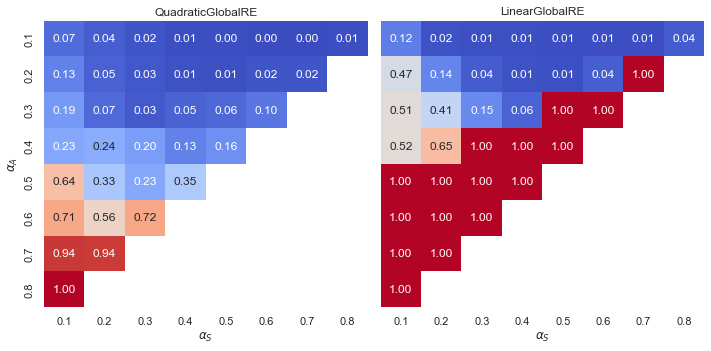

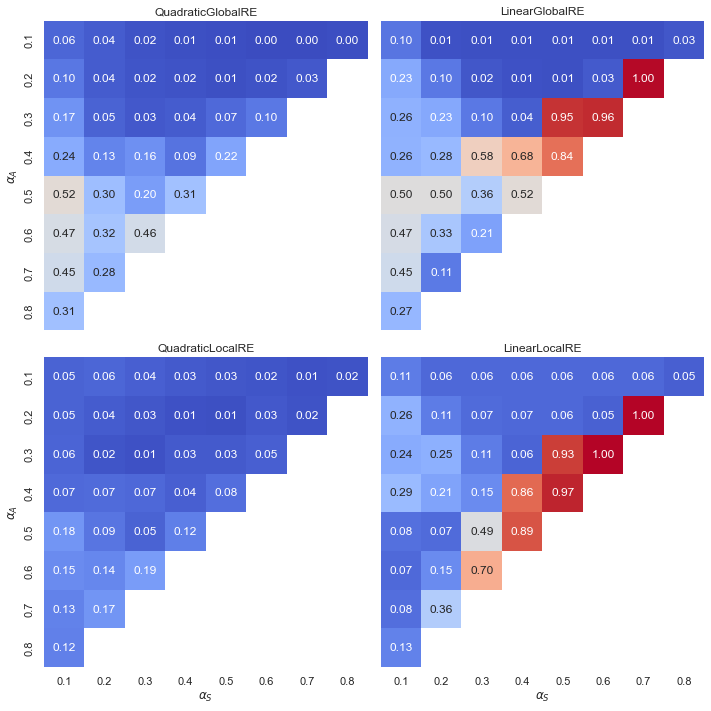

In [220]:
for data, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdata = data[data["model_name"].isin(go_models)]
    else:
        rdata=data

    endpoint = "global opima" if endpoint_type == "go" else "fixed points"
    
    if (analyse_branches) & (endpoint_type=="fp"):
        endpoint += " (all branches)"
    
    heat_maps_by_weights(re_data = rdata, 
                     values = "{}_full_re_state".format(endpoint_type), 
                     #title = 'Relative share of full RE states among {}'.format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.3f}',
                     vmin=0, vmax=1,
                     bootstrap=bootstrap,
                     n_resamples=n_resamples)
    
    
    branches = "pp" if analyse_branches else "rp"
        
    if export_results:
        plt.savefig(path.join(figures_output_dir, 'hm_rel_{}_full_re_{}.png'.format(endpoint_type, branches)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'hm_rel_{}_full_re_{}.pdf'.format(endpoint_type, branches)), bbox_inches='tight')
        
    plt.show()